# VCF File Parser

A parser for Variant Call Format (VCF) files supporting both uncompressed (`.vcf`) and compressed (`.vcf.gz`) formats.

**Features:**
- Parses VCF v4.1/4.2/4.3 files
- Handles both `.vcf` and `.vcf.gz` (bgzip/gzip) compressed files
- Stores results in a pandas DataFrame (optimal for columnar variant data)
- Preserves metadata and header information
- Unit tested with generated sample data
- Performance benchmarked with visualizations

## Prompt: 

Create a jupyter notebook from scratch(do not reference other files) that contains code for a VCF parser, accounting for uncompressed and compressed files, and storing the results using an optimal data structure. Generate sample files for testing the code and unit test cases to evaluate the functionality of the code. Lastly, create 3-5 visualizations that communicate the performance benchmarks, coverage metrics, and statistics about the parsed VCF file. 


## 1. Imports and Setup

In [1]:
#Import the necessary python libraries needed to run the code.
import gzip
import os
import time
import random
import unittest
import tempfile
import shutil
from dataclasses import dataclass, field
from io import StringIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#Setup for the visualizations towards the end of the code.
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({"figure.dpi": 120, "font.size": 10})

## 2. VCF Parser Implementation

In [ ]:
@dataclass #A decorator function that creates methods for the function automatically, to save space writing additional code.
class VCFHeader:
    """Stores parsed VCF header information."""
    meta_lines: list = field(default_factory=list)      # raw ## lines
    info_fields: dict = field(default_factory=dict)      # INFO definitions
    format_fields: dict = field(default_factory=dict)    # FORMAT definitions
    filter_fields: dict = field(default_factory=dict)    # FILTER definitions
    contig_fields: dict = field(default_factory=dict)    # contig definitions
    sample_ids: list = field(default_factory=list)       # sample column names
    file_format: str = ""                                # VCF version string


class VCFParser:
    """Parser for VCF files (uncompressed and gzip-compressed).

    Results are stored in a pandas DataFrame – an optimal columnar
    data structure for variant data that supports fast filtering,
    grouping, and statistical operations.
    """

    MANDATORY_COLS = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"]#A list of all the column names present in a VCF file.

    def __init__(self, filepath: str):
        self.filepath = filepath#Initializing a variable that contains the filepath.
        self.header = VCFHeader()#Initializes a variable that contains empty datastructures to store header information created from the VCFHeader class.
        self.variants: pd.DataFrame = pd.DataFrame()#Initialize a variable and assigns an empty dataframe that will be used to store variants.
        self._parse_time: float = 0.0 #Initializes a variable that is used to track runtime of parsing.

    # ---- public API --------------------------------------------------------

    def parse(self) -> pd.DataFrame:#Defining the parse function indicating that a pandas dataframe will be returned.
        """Parse the VCF file and return a DataFrame of variant records."""
        start = time.perf_counter()
        opener = self._get_opener()
        header_lines = []
        data_lines = []

        try:
            with opener(self.filepath, "rt") as fh:#Opens the VCF file.
                for line in fh:#Loops through all lines of the VCF file.
                    line = line.rstrip("\n")#Remove any whitespace from the line if there is any after the text.
                    if line.startswith("##"):#Checks if any of the lines starts with ## indicating a header line
                        header_lines.append(line)#If the line contains ##, add it to the list header_lines
                    elif line.startswith("#CHROM"):#Checks if the the line starts with #CHROM
                        header_lines.append(line)#Then append this line to the list with all the header information.
                        self._parse_column_header(line)#Extracts the sample IDs using the private helper function _parser_column_header function.
                    else:
                        if line:  # skip blank lines
                            data_lines.append(line)#If the line is not a part of the header information, then it must contain variant information and so it is appended to the data_lines list.
        except FileNotFoundError:#If the file isn't found
            raise FileNotFoundError(f"VCF file not found: {self.filepath!r}")#Raise an error that the file isn't found.
        except PermissionError:#If the permissions are incorrect
            raise PermissionError(f"Permission denied when reading: {self.filepath!r}")#Raise an error that Permission was denied.
        except (gzip.BadGzipFile, EOFError) as e:#If the compressed file is damaged or incomplete.
            raise ValueError(f"Corrupt or invalid gzip file {self.filepath!r}: {e}") from e#Raise an error that the gzip file is corrupt.
        except OSError as e:#If a file system error occurs.
            raise OSError(f"Could not read VCF file {self.filepath!r}: {e}") from e#Raise an error that the VCF file could not be read.

        try:#Tries to read the VCF file.
            self._parse_meta(header_lines)#Creates a dictionary with the header lines sorted into their corresponding data structures.
            self._build_dataframe(data_lines)#Build a dataframe of all the variant information.
        except Exception as e:#If there is an error
            raise RuntimeError(f"Failed to parse VCF content in {self.filepath!r}: {e}") from e#Raise an error that the VCF content could not be parsed.

        self._parse_time = time.perf_counter() - start#Calculate the time it took to parse the file.
        return self.variants#Returns dataframe containing all the variant information.

    def summary(self) -> dict:#Defines a function that returns a dictionary.
        """Return summary statistics about the parsed VCF."""
        if self.variants.empty:#If the dictionary is empty
            return {}#Return an empty dictionary.
        df = self.variants#Setting df equal to the dataframe containing the variant information.
        return {#Dictionary of summary statistics.
            "total_variants": len(df),#Counts the total number of variants.
            "chromosomes": sorted(df["CHROM"].unique().tolist()),#Gets the different chromosomes(removes duplicates) and stores them in a list.
            "num_chromosomes": df["CHROM"].nunique(),#Counts the number of chromosomes(removing duplicates)
            "variant_types": self._classify_variants().value_counts().to_dict(),#Calls the private helper function _classify_variants() to identify the kind of variant, then counts the number of each kind of variant and stores in a dictionary.
            "filter_counts": df["FILTER"].value_counts().to_dict(),#Counts number of filters and stores in a dictionary.
            "mean_quality": float(df["QUAL"].mean()) if df["QUAL"].dtype != object else None,#Calculates the mean from the QUAL column, and checks if the values are integers, then only calculate the mean otherwise set the value to None.
            "num_samples": len(self.header.sample_ids),#The number samples.
            "parse_time_sec": round(self._parse_time, 4),#The time it took to parse the file. 
        }

    # ---- private helpers ---------------------------------------------------

    def _get_opener(self):#A private helper function
        """Return the appropriate file opener based on extension."""
        if self.filepath.endswith(".gz"):#Checks if the filepath ends with .gz
            return gzip.open#Uncompresses the gzipped file)
        if not self.filepath.endswith(".vcf"):#Rejects file extensions that are not .vcf or .vcf.gz
            raise ValueError(
                f"Unsupported file extension: {self.filepath!r}. Expected '.vcf' or '.vcf.gz'."
            )
        return open#Opens the file.

    def _parse_column_header(self, line: str):#A private helper function that takes line(a string) as input.
        """Parse the #CHROM header line to extract sample IDs."""
        cols = line.lstrip("#").split("\t")#Split the lines by the tab and remove any whitespace on the left of the #
        if len(cols) > 9:  # FORMAT + sample columns present
            self.header.sample_ids = cols[9:]#Only store values after the 9th index into self.header.sample_ids.

    def _parse_meta(self, header_lines: list):#A private helper function that takes the header_lines(a list) as input.
        """Parse ## meta-information lines."""
        for line in header_lines:
            if not line.startswith("##"):#Skips all the lines that are not header lines.
                continue#Skip the rest of the loop and continue to the next iteration.
            self.header.meta_lines.append(line)#Add the line to the meta_lines list from the VCFHeader Class.
            key_value = line[2:]  # strip leading ##. Takes only the content, excluding the formatting.

            if key_value.startswith("fileformat="):#Checks to see what is this line is the file format line.
                self.header.file_format = key_value.split("=", 1)[1]#Set the file format string equal to the content after the equal sign.
            elif key_value.startswith("INFO="):#Checks if the header line starts with INFO
                parsed = self._parse_structured_field(key_value[5:])#Creates a dictionary called parsed with the metadata inside of the header line.
                if parsed and "ID" in parsed:#If the parsed dictionary for this line is not empty and has a key called ID,
                    self.header.info_fields[parsed["ID"]] = parsed#The ID is used as a key to store the entire dictionary for the line.
            elif key_value.startswith("FORMAT="):#Checks if the header line starts with FORMAT
                parsed = self._parse_structured_field(key_value[7:])#Creates a dictionary with the format fields as key/value pairs for that header line.
                if parsed and "ID" in parsed:#Checks if the dictionary parsed is not empty and if it has a key called ID.
                    self.header.format_fields[parsed["ID"]] = parsed#Sets the key for the self.header.format_fields dictionary key and the resulting dictionary as the value.
            elif key_value.startswith("FILTER="):#Checks if the header line starts with FILTER
                parsed = self._parse_structured_field(key_value[7:])#Creates a dictionary called parsed that contains all of the FILTER fields as key/value pairs.
                if parsed and "ID" in parsed:#Checks if the parsed dictionary is not empty and has a key called ID.
                    self.header.filter_fields[parsed["ID"]] = parsed#Sets the key of the self.header.filter_fields dictionary to the ID of the parsed dictionary and the dictioanry as the value.
            elif key_value.startswith("contig="):#Checks if the header line starts with contig=
                parsed = self._parse_structured_field(key_value[7:])#Creates a dictionary called parsed that contains all of the contig fields as key/value pairs.
                if parsed and "ID" in parsed:#Checks if the parsed dictionary is not empty and has a key called ID.
                    self.header.contig_fields[parsed["ID"]] = parsed#Sets the key of the self.header.contig_fields dictionary to the ID of the parsed dictionary and the dictioanry as the value.

    @staticmethod#A helper function that works independently of a class.
    def _parse_structured_field(raw: str) -> dict: #Defines a function that returns a dictionary and takes a string as input.
        """Parse a <key=value,...> structured header field."""
        raw = raw.strip()#Removes any whitespace from the string.
        if raw.startswith("<") and raw.endswith(">"):#Checks if the string starts with < and ends with >.
            raw = raw[1:-1]#Updates the variable raw to contain the string in between the <>.
        result = {}#Creates a dictionary.
        # Handle Description which may contain commas inside quotes
        parts = []
        buf = []
        in_quotes = False
        for ch in raw:#Loops through characters in the string assigned to the raw variable.
            if ch == '"':
                in_quotes = not in_quotes#When encountering a quote, set in_quotes to True
                buf.append(ch)#Add the quote character to the list
            elif ch == ',' and not in_quotes: #If the character is a comma and is also is not inside quotes.
                parts.append(''.join(buf))#Join all characters in the list and add to a list called parts.
                buf = []#Empty the buf list
            else:#If just a normal character
                buf.append(ch)#Add character to buf list
        if buf:#Contents left after the last comma
            parts.append(''.join(buf))#Add the remaining contents to the parts list.

        for part in parts:#For every string in the list parts, 
            if '=' in part:#If there is an = in the string
                k, v = part.split('=', 1)#Split the string into two parts with k containing the string before the equal sign and v to the content after the equal sign.
                result[k.strip()] = v.strip().strip('"')#Removes the quotes and unnecessary white space and adds values to the dictionary.
        return result#Returns a dictionary with the components inside of the specific header line.

    def _build_dataframe(self, data_lines: list):
        """Convert raw data lines into a typed pandas DataFrame."""
        if not data_lines:#If the data_lines list is empty
            self.variants = pd.DataFrame(columns=self.MANDATORY_COLS)#Set the dataframe columns with the column names in self.MANDATORY_COLS.
            return#Return an empty dataframe.

        all_cols = self.MANDATORY_COLS.copy()#Create a copy of the column names without modifying the original list.
        has_format = len(self.header.sample_ids) > 0#Checks if there are sample IDs. Boolean type variable.
        if has_format:#If has_format has at least one sample ID
            all_cols.append("FORMAT")#Create a column called FORMAT
            all_cols.extend(self.header.sample_ids)#Add columns for the sample ID names.

        rows = [line.split("\t") for line in data_lines]#Create a list of lists of variants split by their column.
        df = pd.DataFrame(rows)#Create a data frame with each nested list as a row in the dataframe.
        # Assign column names for however many columns we actually got 
        df.columns = all_cols[: len(df.columns)]

        # Type conversions
        df["POS"] = pd.to_numeric(df["POS"], errors="coerce").astype("Int64")#Convert strings to integers.
        df["QUAL"] = pd.to_numeric(df["QUAL"].replace(".", np.nan), errors="coerce")#Convert value to float.
        df["CHROM"] = df["CHROM"].astype("category")#Stores as a value that can be referenced easier.
        df["FILTER"] = df["FILTER"].astype("category")#Stores as a value that can be referenced easier.

        self.variants = df#Set the empty dataframe that was initalized in the VCFParser class to the resulting dataframe.

    def _classify_variants(self) -> pd.Series:#defines a private function that returns an indexed single column of data.
        """Classify each variant as SNP, INS, DEL, or MNV."""
        def classify(row):#Defines a nested function with the input being the row of the dataframe(a specific variant)
            ref, alt = row["REF"], str(row["ALT"]).split(",")[0]#stores the value of the reference and the alternate columns in ref and alt variables. Splits the values by the comma if there is more than one value.
            if len(ref) == 1 and len(alt) == 1:#If the length of values for both variables is equal to 1
                return "SNP"#Return SNP
            elif len(ref) > len(alt):#If the length of the values of ref is greater than the length of values in the list for alt
                return "DEL"#Return DEL, meaning this is a deletion.
            elif len(ref) < len(alt):#If the length of the values for the list for ref is less than the length of the list for alt
                return "INS"#Return INS, meaning this is an insertion.
            else:#Everything else
                return "MNV"#Return MNV, meaning Multiple Nucleotide Variant.
        return self.variants.apply(classify, axis=1)#Classifies each of the rows in the self.variants dataframe as one of the variants.

## 3. Sample VCF File Generation

In [3]:
def generate_sample_vcf(filepath: str, num_variants: int = 200,
                        num_samples: int = 3, compressed: bool = False,
                        seed: int = 42):# define a function that generates a sample vcf file. The input is the filepath, number of variants, number of samples, a boolean indicating if the file is compressed, and seed number.
    """Generate a synthetic VCF file for testing."""
    rng = random.Random(seed)#Seed is used to ensure we are getting the same data every time.
    bases = "ACGT"
    chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]#Chromosome names
    sample_names = [f"SAMPLE_{i+1}" for i in range(num_samples)]#Create sample names
    filters = ["PASS", "PASS", "PASS", "PASS", "LowQual", "LowDP"]#List of possible filters

    lines = []
    # -- meta-information
    lines.append("##fileformat=VCFv4.2")#Append header information. This is the file version.
    lines.append('##INFO=<ID=DP,Number=1,Type=Integer,Description="Total read depth">')#INFO fields provide annotations about the variants.
    lines.append('##INFO=<ID=AF,Number=A,Type=Float,Description="Allele frequency">')
    lines.append('##INFO=<ID=MQ,Number=1,Type=Float,Description="Mapping quality">')
    lines.append('##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">')#FORMAT fields define the structure of the genotype data.
    lines.append('##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Sample read depth">')
    lines.append('##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype quality">')
    lines.append('##FILTER=<ID=LowQual,Description="Low quality variant">')#FILTER fields define quality control filters. and whether a variant passes.
    lines.append('##FILTER=<ID=LowDP,Description="Low depth variant">')
    for c in chroms:#For each chromosome
        lines.append(f'##contig=<ID={c},length={rng.randint(50_000_000, 250_000_000)}>')#Create a contig header for that chromosomes with a randomly generated length between 50000000 and 250000000 base pairs.

    # -- column header
    cols = ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"]#Column names
    cols.extend(sample_names)#Add sample names
    lines.append("\t".join(cols))#Convert the list into a string with a tab in between each string.

    # -- variant records
    genotypes = ["0/0", "0/1", "1/1", "0/0", "0/1"]#List of possible genotypes.
    for i in range(num_variants):#Loops through number of variants.
        chrom = rng.choice(chroms)#Chooses a different chromosome each time.
        pos = rng.randint(1, 200_000_000)#Chooses a location on the chromosome
        vid = f"rs{rng.randint(100000, 9999999)}" if rng.random() > 0.3 else "."#70% of the time, create a random variant ID, and 30% of the time just use .
        ref = rng.choice(bases)#Randomly choose a reference base.

        # create different variant types
        vtype = rng.random()#Creates a number between 0 and 1.
        if vtype < 0.65:  # SNP
            alt = rng.choice([b for b in bases if b != ref])#Choose a base that is not equal to the ref.
        elif vtype < 0.80:  # insertion
            alt = ref + ''.join(rng.choice(bases) for _ in range(rng.randint(1, 5)))#Add 1-5 random bases to the alternate.
        elif vtype < 0.95:  # deletion
            ref = ref + ''.join(rng.choice(bases) for _ in range(rng.randint(1, 5)))#Add 1-5 random bases to the reference.
            alt = ref[0]#Set the alternate to only the first base.
        else:  # multi-allelic SNP
            alts = rng.sample([b for b in bases if b != ref], 2)#Pick 2 different alleles than the reference.
            alt = ",".join(alts)

        qual = round(rng.uniform(5, 10000), 1)#Creates a random quality score
        filt = rng.choice(filters)#Chooses a random filter
        dp = rng.randint(5, 500)#Chooses a random read depth between 5 and 500.
        af = round(rng.uniform(0.01, 1.0), 4)#Chooses a random decimal and rounds to 4 decimals, this is the allele frequency.
        mq = round(rng.uniform(20, 60), 1)#Chooses a number between 20 and 60 and rounds to the tenths place. This is the mapping quality.
        info = f"DP={dp};AF={af};MQ={mq}"#Combines the metrics to create the INFO header line.
        fmt = "GT:DP:GQ"#Formatting strings.

        sample_data = []
        for _ in sample_names:#Iterates through the sample_names
            gt = rng.choice(genotypes)#Chooses a random genotype
            sdp = rng.randint(1, 200)#Chooses a random integer between 1 and 200 to resemble the sample depth.
            gq = rng.randint(1, 99)#Choose a number to resemble the genotype quality.
            sample_data.append(f"{gt}:{sdp}:{gq}")#Append this information to the sample data.

        fields = [chrom, str(pos), vid, ref, alt, str(qual), filt, info, fmt]#The relevant fields for the variant stored in a list.
        fields.extend(sample_data)#Add the sample data.
        lines.append("\t".join(fields))#Convert the list to a string separated by a tab.

    content = "\n".join(lines) + "\n"#Joins all the lines separated by a new line.

    if compressed:#Checks if the file is compressed
        with gzip.open(filepath, "wt") as f:#Uncompresses the file and opens it.
            f.write(content)#Writes content to the file
    else:#If not compressed
        with open(filepath, "w") as f:#Opens file
            f.write(content)#Writes content to the file.

    return filepath#Returns the name of the file.

In [18]:
# Generate sample files
os.makedirs("test_data", exist_ok=True)#Create a test_data directory.

sample_vcf = generate_sample_vcf("test_data/sample.vcf", num_variants=200)#Creates test file.
sample_vcf_gz = generate_sample_vcf("test_data/sample.vcf.gz", num_variants=200, compressed=True)#Create test compressed file.
large_vcf = generate_sample_vcf("test_data/large.vcf", num_variants=5000, seed=99)#Creates a large VCF file.
empty_vcf = generate_sample_vcf("test_data/empty.vcf", num_variants=0)#Creates an empty VCF file.
single_vcf = generate_sample_vcf("test_data/single.vcf", num_variants=1)#Creates a VCF file with a single entry.

print("Generated test files:")
for f in sorted(os.listdir("test_data")):#Iterates through each file in test_data.
    size = os.path.getsize(os.path.join("test_data", f))#Gets the size of the file.
    print(f"  {f:25s}  {size:>8,} bytes")#Prints the size.

Generated test files:
  .ipynb_checkpoints              128 bytes
  benchmark_parse_time.png     61,244 bytes
  chromosome_coverage.png      42,397 bytes
  compression_ratio.png        40,027 bytes
  empty.vcf                     1,471 bytes
  large.vcf                   525,915 bytes
  quality_and_filters.png      46,516 bytes
  sample.vcf                   22,557 bytes
  sample.vcf.gz                 8,509 bytes
  single.vcf                    1,577 bytes
  variant_types.png            35,359 bytes


## 4. Quick Parse Demo

In [4]:
parser = VCFParser("test_data/sample.vcf")#Creates an object called parser that calls the VCFParser class on the sample.vcf file in test data.
df = parser.parse()#Calls the parse method from the VCFParser class.

print("Parsed VCF summary:")
for k, v in parser.summary().items():#Iterates through the key/value pairs in the resulting dictionary.
    print(f"  {k}: {v}")#Prints the results.

print("\nFirst 5 variants:")
df.head()#Shows the first 5 variants present in the dataframe.

Parsed VCF summary:
  total_variants: 200
  chromosomes: ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX', 'chrY']
  num_chromosomes: 24
  variant_types: {'SNP': 143, 'DEL': 33, 'INS': 24}
  filter_counts: {'PASS': 129, 'LowDP': 37, 'LowQual': 34}
  mean_quality: 4941.945
  num_samples: 3
  parse_time_sec: 0.0302

First 5 variants:


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE_1,SAMPLE_2,SAMPLE_3
0,chr18,53375075,rs9242600,T,G,2785.5,PASS,DP=393;AF=0.8078;MQ=47.9,GT:DP:GQ,1/1:72:20,0/1:196:44,0/0:24:49
1,chr4,96362793,rs4537923,A,AATAGG,5775.6,LowDP,DP=40;AF=0.0554;MQ=29.1,GT:DP:GQ,1/1:21:30,0/0:98:36,0/0:163:47
2,chr6,99369697,rs4579144,A,C,5343.7,PASS,DP=88;AF=0.4676;MQ=30.8,GT:DP:GQ,0/1:57:88,1/1:197:8,0/1:9:41
3,chr13,71871146,.,G,C,3959.3,LowDP,DP=239;AF=0.1514;MQ=25.6,GT:DP:GQ,0/1:138:34,0/1:110:75,0/0:93:29
4,chr5,136774923,rs890481,A,C,7921.8,PASS,DP=310;AF=0.0729;MQ=35.3,GT:DP:GQ,0/0:136:33,0/1:3:88,0/0:175:69


In [5]:
# Also parse compressed file
parser_gz = VCFParser("test_data/sample.vcf.gz")#Creates an object called parser_gz that calls the VCFParser class on the sample.vcf.gz file from test_data.
df_gz = parser_gz.parse()#Calls the parse method from the VCFParser class.

print(f"Compressed parse: {len(df_gz)} variants in {parser_gz._parse_time:.4f}s")#Count number of variants and time it took to parse.
print(f"VCF version: {parser_gz.header.file_format}")#Prints version of VCF file.
print(f"Samples: {parser_gz.header.sample_ids}")#Prints the sample ID names.
print(f"INFO fields defined: {list(parser_gz.header.info_fields.keys())}")#Prints the INFO fields.
print(f"FILTER fields defined: {list(parser_gz.header.filter_fields.keys())}")#Prints the FILTER fields.

Compressed parse: 200 variants in 0.0050s
VCF version: VCFv4.2
Samples: ['SAMPLE_1', 'SAMPLE_2', 'SAMPLE_3']
INFO fields defined: ['DP', 'AF', 'MQ']
FILTER fields defined: ['LowQual', 'LowDP']


## 5. Unit Tests

In [6]:
class TestVCFParser(unittest.TestCase):#Creates a class containing the unit tests for the VCF Parser.
    """Unit tests for VCFParser."""

    @classmethod#Decorator function in which you can call on the class itself.
    def setUpClass(cls):
        cls.tmpdir = tempfile.mkdtemp()#Creates a temporary folder
        cls.vcf_path = os.path.join(cls.tmpdir, "test.vcf")#Adds a test.vcf file to the temporary directory.
        cls.vcf_gz_path = os.path.join(cls.tmpdir, "test.vcf.gz")#Adds a test compressed VCF file to the temporary directory.
        cls.empty_path = os.path.join(cls.tmpdir, "empty.vcf")#Adds an empty VCF file to the directory.
        generate_sample_vcf(cls.vcf_path, num_variants=100, seed=1)#Creates the uncompressed VCF file.
        generate_sample_vcf(cls.vcf_gz_path, num_variants=100, seed=1, compressed=True)#Creates the compressed VCF file.
        generate_sample_vcf(cls.empty_path, num_variants=0, seed=1)#Creates the empty VCF file.

    @classmethod
    def tearDownClass(cls):#Deletes the temporary directory.
        shutil.rmtree(cls.tmpdir)

    # -- Basic parsing tests -------------------------------------------------

    def test_parse_returns_dataframe(self):
        parser = VCFParser(self.vcf_path)#Create a parser object, calling the VCFParser class.
        result = parser.parse()#Run the parser.
        self.assertIsInstance(result, pd.DataFrame)#Check if the result is a pandas Dataframe. If so, it passes the test, otherwise it fails.

    def test_correct_variant_count(self):
        parser = VCFParser(self.vcf_path)#Create a parser object, calling the VCFParser class.
        parser.parse()#Run the parser.
        self.assertEqual(len(parser.variants), 100)#Check if the number of variants is equal to a 100 which is defined when creating the sample files.

    def test_mandatory_columns_present(self):
        parser = VCFParser(self.vcf_path)#Create a parser object, calling the VCFParser class.
        parser.parse()#Run the parser.
        for col in VCFParser.MANDATORY_COLS:#Iterates through the mandatory column names
            self.assertIn(col, parser.variants.columns)#Checks if column name is present in the dataframe.

    def test_pos_is_numeric(self):
        parser = VCFParser(self.vcf_path)#Create a parser object, calling the VCFParser class.
        parser.parse()#Run the parser.
        self.assertTrue(pd.api.types.is_integer_dtype(parser.variants["POS"]))#Checks the POS column in the dataframe and checks if values are an integer.

    def test_qual_is_numeric(self):
        parser = VCFParser(self.vcf_path)#Create a parser object, calling the VCFParser class.
        parser.parse()#Run the parser.
        self.assertTrue(pd.api.types.is_float_dtype(parser.variants["QUAL"]))#Checks the QUAL column in the dataframe and checks if the values are floats.

    # -- Compressed file tests -----------------------------------------------

    def test_compressed_parse(self):#Testing the compressed file.
        parser = VCFParser(self.vcf_gz_path)#Create a parser object, calling the VCFParser class.
        parser.parse()#Run the parser.
        self.assertEqual(len(parser.variants), 100)#Checks if the number of variants in the file is equal to a 100 which is specified when creating the file.

    def test_compressed_matches_uncompressed(self):
        p1 = VCFParser(self.vcf_path)#Create a parser object, calling the VCFParser class.
        p1.parse()#Run the parser.
        p2 = VCFParser(self.vcf_gz_path)#Create a parser object, calling the VCFParser class.
        p2.parse()#Run the parser.
        pd.testing.assert_frame_equal(p1.variants, p2.variants)#Checks if the columns of both dataframes are the same.

    # -- Header tests --------------------------------------------------------

    def test_file_format_parsed(self):
        parser = VCFParser(self.vcf_path)#Create a parser object, calling the VCFParser class.
        parser.parse()#Run the parser.
        self.assertEqual(parser.header.file_format, "VCFv4.2")#Checks if the file format is the version VCFv4.2.

    def test_info_fields_parsed(self):
        parser = VCFParser(self.vcf_path)#Create a parser object, calling the VCFParser class.
        parser.parse()#Run the parser.
        self.assertIn("DP", parser.header.info_fields)#Checks if DP is present in the infofields.
        self.assertIn("AF", parser.header.info_fields)#Checks if AF is present in the info fields.

    def test_sample_ids_parsed(self):
        parser = VCFParser(self.vcf_path)#Create a parser object, calling the VCFParser class.
        parser.parse()#Run the parser.
        self.assertEqual(len(parser.header.sample_ids), 3)#Checks if there are 3 sample IDs.
        self.assertEqual(parser.header.sample_ids[0], "SAMPLE_1")#Checks if the first sample ID is called SAMPLE_1.

    def test_filter_fields_parsed(self):
        parser = VCFParser(self.vcf_path)#Create a parser object, calling the VCFParser class.
        parser.parse()#Run the parser.
        self.assertIn("LowQual", parser.header.filter_fields)#Checks if LowQual is present in filter_fields.

    def test_contig_fields_parsed(self):
        parser = VCFParser(self.vcf_path)#Create a parser object, calling the VCFParser class.
        parser.parse()#Run the parser.
        self.assertGreater(len(parser.header.contig_fields), 0)#Checks if there is at least one contig.

    # -- Edge case tests -----------------------------------------------------

    def test_empty_vcf(self):
        parser = VCFParser(self.empty_path)#Create a parser object, calling the VCFParser class.
        parser.parse()#Run the parser.
        self.assertEqual(len(parser.variants), 0)#Checks if there are 0 contigs.
        self.assertIn("CHROM", parser.variants.columns)#Check if the column CHROM is present in the column names of the dataframe.

    def test_summary_keys(self):
        parser = VCFParser(self.vcf_path)#Create a parser object, calling the VCFParser class.
        parser.parse()#Run the parser.
        s = parser.summary()#Get summary statistics.
        expected_keys = ["total_variants", "chromosomes", "num_chromosomes",
                         "variant_types", "filter_counts", "mean_quality",
                         "num_samples", "parse_time_sec"]
        for key in expected_keys:#Loops through the list of expected keys.
            self.assertIn(key, s)#Checks if the key is present in the summary statistics computed.

    def test_summary_empty_vcf(self):
        parser = VCFParser(self.empty_path)#Create a parser object, calling the VCFParser class.
        parser.parse()#Run the parser.
        self.assertEqual(parser.summary(), {})#Checks that the summary statistics for the empty VCF file is empty.

    def test_chrom_is_categorical(self):
        parser = VCFParser(self.vcf_path)#Create a parser object, calling the VCFParser class.
        parser.parse()#Run the parser.
        self.assertIsInstance(parser.variants["CHROM"].dtype, pd.CategoricalDtype)#Checks if the values of the CHROM column are of the categorical data type.

    def test_parse_time_recorded(self):
        parser = VCFParser(self.vcf_path)#Create a parser object, calling the VCFParser class.
        parser.parse()#Run the parser.
        self.assertGreater(parser._parse_time, 0)#Checks if the time to parse the file is greater than 0s.


# Run tests inside the notebook
suite = unittest.TestLoader().loadTestsFromTestCase(TestVCFParser)#Creates a testloader object, finds all the testing methods in the TestVCFParser class and stores them in suite.
runner = unittest.TextTestRunner(verbosity=2)#Allows all tests to be run together.
result = runner.run(suite)#Run the tests.

print(f"\n{'='*60}")#Formatting
print(f"Tests run: {result.testsRun}")#Prints the number of tests that ran.
print(f"Failures: {len(result.failures)}")#Prints the number of tests that failed.
print(f"Errors: {len(result.errors)}")#Prints the number of errors.

test_chrom_is_categorical (__main__.TestVCFParser.test_chrom_is_categorical) ... ok
test_compressed_matches_uncompressed (__main__.TestVCFParser.test_compressed_matches_uncompressed) ... ok
test_compressed_parse (__main__.TestVCFParser.test_compressed_parse) ... ok
test_contig_fields_parsed (__main__.TestVCFParser.test_contig_fields_parsed) ... ok
test_correct_variant_count (__main__.TestVCFParser.test_correct_variant_count) ... ok
test_empty_vcf (__main__.TestVCFParser.test_empty_vcf) ... ok
test_file_format_parsed (__main__.TestVCFParser.test_file_format_parsed) ... ok
test_filter_fields_parsed (__main__.TestVCFParser.test_filter_fields_parsed) ... ok
test_info_fields_parsed (__main__.TestVCFParser.test_info_fields_parsed) ... ok
test_mandatory_columns_present (__main__.TestVCFParser.test_mandatory_columns_present) ... ok
test_parse_returns_dataframe (__main__.TestVCFParser.test_parse_returns_dataframe) ... ok
test_parse_time_recorded (__main__.TestVCFParser.test_parse_time_recorded)


Tests run: 17
Failures: 0
Errors: 0


## 6. Visualizations

### 6.1 — Performance Benchmark: Parse Time vs File Size

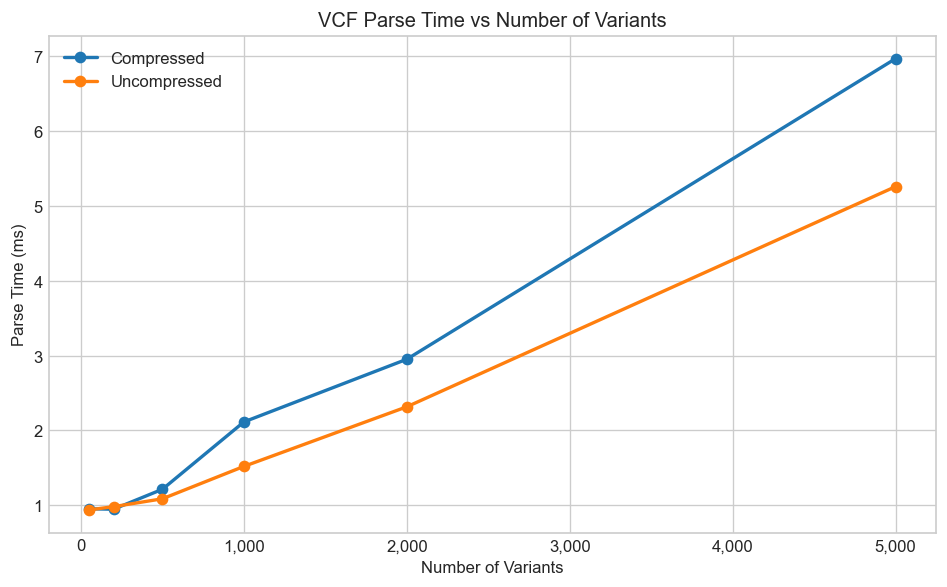

In [7]:
# Benchmark parsing across different file sizes
benchmark_sizes = [50, 200, 500, 1000, 2000, 5000]#List of different sizes of files.
bench_dir = tempfile.mkdtemp()#Create a temporary directory.
results = {"format": [], "num_variants": [], "parse_time": [], "file_size_kb": []}#Create an empty dictionary which will have data added to it.

for n in benchmark_sizes:#Iterate through the benchmark sizes.
    for fmt, ext, comp in [("Uncompressed", ".vcf", False), ("Compressed", ".vcf.gz", True)]:#Iterate through tuples containing format for each file
        path = os.path.join(bench_dir, f"bench_{n}{ext}")#Creates the path to which the file will be stored.
        generate_sample_vcf(path, num_variants=n, compressed=comp, seed=42)#Creates a test VCF file with the specified settings.
        fsize = os.path.getsize(path) / 1024#Get the file size.

        times = []
        for _ in range(3):#3 runs for stable timing
            p = VCFParser(path)#Create an object calling the VCFParser class
            p.parse()#Run the parser.
            times.append(p._parse_time)#Add the time that it took to parse to a list called times.

        results["format"].append(fmt)#Add the file type to the results dictionary with format as the key.
        results["num_variants"].append(n)#Add the number of variants to the results dictionary with num_variants as the key.
        results["parse_time"].append(np.median(times))#Add the median time it took to parse the file to the results dictionary with parse_time as the key.
        results["file_size_kb"].append(fsize)#Add the size of the file to the results dictionary with file_size_kb as the key.

shutil.rmtree(bench_dir)#Delets the temporary directory and everything inside it.
bench_df = pd.DataFrame(results)#Creates a dataframe using the dictionary.

fig, ax = plt.subplots(figsize=(8, 5))#Creates a plot that is 8 inches wide and 5 inches tall.
for fmt, grp in bench_df.groupby("format"):#Creates two different lines based on format(compressed or uncompressed)
    ax.plot(grp["num_variants"], grp["parse_time"] * 1000,#Plots the number of variants and the time it took to parse the file.
            marker="o", linewidth=2, label=fmt)
ax.set_xlabel("Number of Variants")#Sets the x-axis label to the Number of variants.
ax.set_ylabel("Parse Time (ms)")#Sets the y-axis label to Parse Time(ms).
ax.set_title("VCF Parse Time vs Number of Variants")#Sets the title of the plot.
ax.legend()#Provides a legend at the top of the plot.
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))#Sets the intervals on the x axis.
plt.tight_layout()#Automatically adjusts spacing so nothing gets cut off.
plt.savefig("test_data/benchmark_parse_time.png", dpi=150)#Saves the figure to a .png file.
plt.show()#Displays the plot.

### 6.2 — Compression Ratio: Uncompressed vs Compressed File Sizes

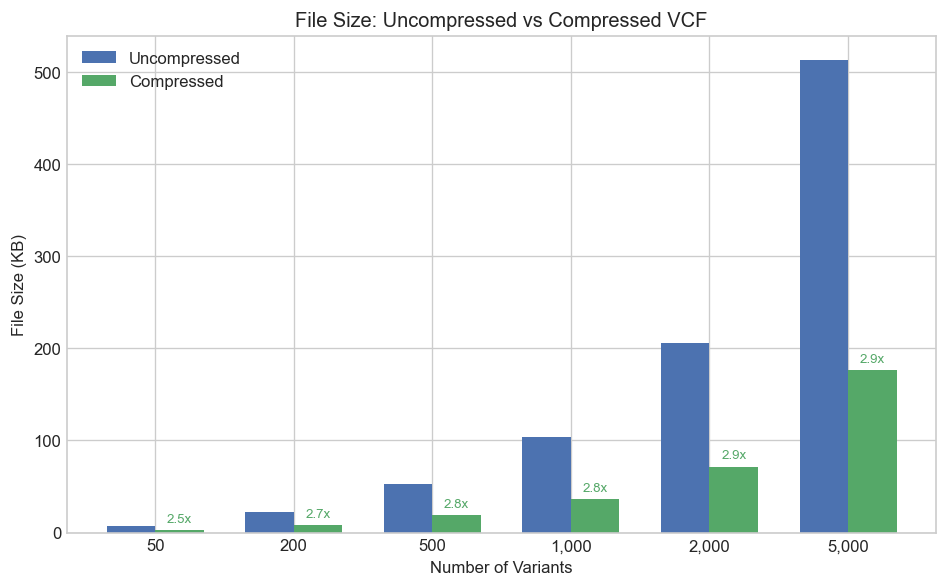

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))#Creates a plot that is 8 inches wide and 5 inches tall.
width = 0.35
uncomp = bench_df[bench_df["format"] == "Uncompressed"]#Retrieves the rows in the dataframe that have an uncompressed format.
comp = bench_df[bench_df["format"] == "Compressed"]#Retrieves the rows in the dataframe that have a compressed format.
x = np.arange(len(benchmark_sizes))#Create a numpy array containing the different benchmark sizes to create the x-axis positions.

bars1 = ax.bar(x - width/2, uncomp["file_size_kb"].values, width, label="Uncompressed", color="#4C72B0")#Sets the position and the length of the bars meant for values in the uncompressed file.
bars2 = ax.bar(x + width/2, comp["file_size_kb"].values, width, label="Compressed", color="#55A868")#Sets the position and the length of the bars meant for values in the compressed file.

# Add compression ratio labels
for i, (u, c) in enumerate(zip(uncomp["file_size_kb"].values, comp["file_size_kb"].values)):#Iterates through the index, and the values for the paired file size values of compressed vs. uncompressed.
    ratio = u / c if c > 0 else 0#Calculates the ratio of file size.
    ax.annotate(f"{ratio:.1f}x", xy=(i + width/2, c), xytext=(0, 5),#Add the ratio to the top of the compressed bars.
                textcoords="offset points", ha="center", fontsize=8, color="#55A868")

ax.set_xlabel("Number of Variants")#Sets the x-axis label to Number of Variants.
ax.set_ylabel("File Size (KB)")#Sets the y-axis label to File Size(KB).
ax.set_title("File Size: Uncompressed vs Compressed VCF")#Sets the title of the plot to File Size: Uncompressed vs Compressed VCF.
ax.set_xticks(x)#Add intervals to the x-axis.
ax.set_xticklabels([f"{s:,}" for s in benchmark_sizes])#Adds the labels to the intervals on the x-axis.
ax.legend()#Adds a label to help the viewer differentiate which bars are meant to indicate compressed vs. uncompressed.
plt.tight_layout()#Automatically adjusts spacing so nothing gets cut off.
plt.savefig("test_data/compression_ratio.png", dpi=150)#Saves the figure to a png file.
plt.show()#Displays the plot.

### 6.3 — Variant Type Distribution

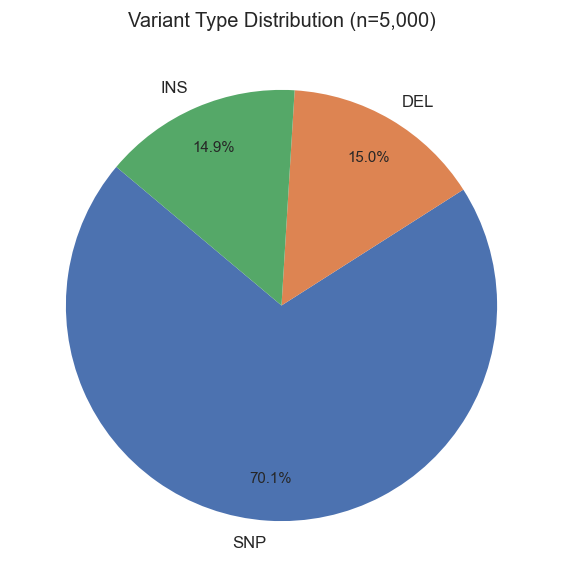

In [9]:
parser_lg = VCFParser("test_data/large.vcf")#Creates an object that calls the VCFParser class on the large.vcf file.
df_lg = parser_lg.parse()#Runs the parser.
vtype_counts = parser_lg._classify_variants().value_counts()#Counts how many of each variant in the file.

fig, ax = plt.subplots(figsize=(6, 5))#Creates a plot that is 6 inches wide and 5 inches tall.
colors = ["#4C72B0", "#DD8452", "#55A868", "#C44E52"]#Colors for the different variant types.
wedges, texts, autotexts = ax.pie(
    vtype_counts.values, labels=vtype_counts.index,
    autopct="%1.1f%%", colors=colors[:len(vtype_counts)],
    startangle=140, pctdistance=0.8
)#Creates a pie chart with the wedge sizes, labels, and percentages.
for t in autotexts:#Iterates through the texts.
    t.set_fontsize(9)#Sets the font to 9.
ax.set_title(f"Variant Type Distribution (n={len(df_lg):,})")#Sets the title of the plot to Variant Type Distribution.
plt.tight_layout()#Automatically adjusts spacing so nothing gets cut off.
plt.savefig("test_data/variant_types.png", dpi=150)#Saves the figure to a png file.
plt.show()#Display the figure.

### 6.4 — Chromosome Coverage: Variants per Chromosome

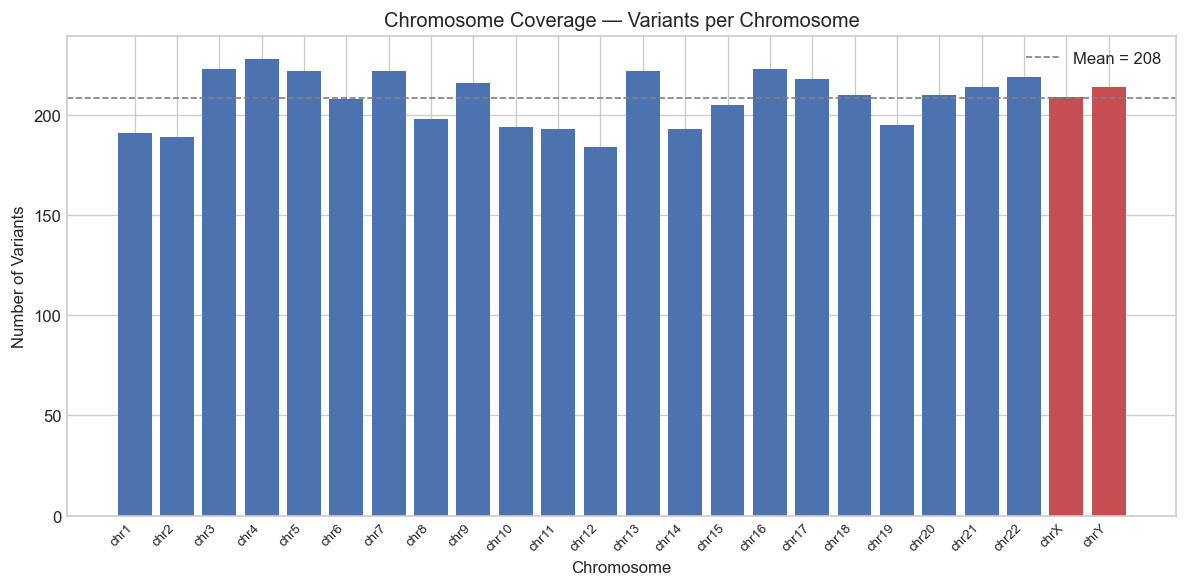

In [10]:
chrom_order = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]#Creates a list of all the chromosomes.
chrom_counts = df_lg["CHROM"].value_counts().reindex(chrom_order, fill_value=0)#Counts the variants per chromosomes and orders them.

fig, ax = plt.subplots(figsize=(10, 5))#Creates a figure that is 10 inches wide and 5 inches tall.
bar_colors = ["#4C72B0" if c not in ("chrX", "chrY") else "#C44E52" for c in chrom_counts.index]#Sets the colors for all chromosomes and different colors for chrX and chrY.
ax.bar(range(len(chrom_counts)), chrom_counts.values, color=bar_colors)#Creates bars for each chromosome.
ax.set_xticks(range(len(chrom_counts)))#Sets the intervals on the x-axis to the number of chromosomes.
ax.set_xticklabels(chrom_counts.index, rotation=45, ha="right", fontsize=8)#Adds labels to each interval.
ax.set_xlabel("Chromosome")#Sets the label for the x-axis to Chromosome.
ax.set_ylabel("Number of Variants")#Sets the y-axis label to Number of variants.
ax.set_title("Chromosome Coverage — Variants per Chromosome")#Sets the title of the plot to Chromosome Coverage - Variants per Chromosome.

mean_val = chrom_counts.mean()#Calculates the mean of the number of variants
ax.axhline(y=mean_val, color="gray", linestyle="--", linewidth=1, label=f"Mean = {mean_val:.0f}")#Adds the grey dashed line for the mean number of variants.
ax.legend()#Adds a legend with the grey line indicating the mean.
plt.tight_layout()#Automatically adjusts spacing so nothing gets cut off.
plt.savefig("test_data/chromosome_coverage.png", dpi=150)#Saves the figure to a png file.
plt.show()#Display the figure.

### 6.5 — Quality Score Distribution & FILTER Status

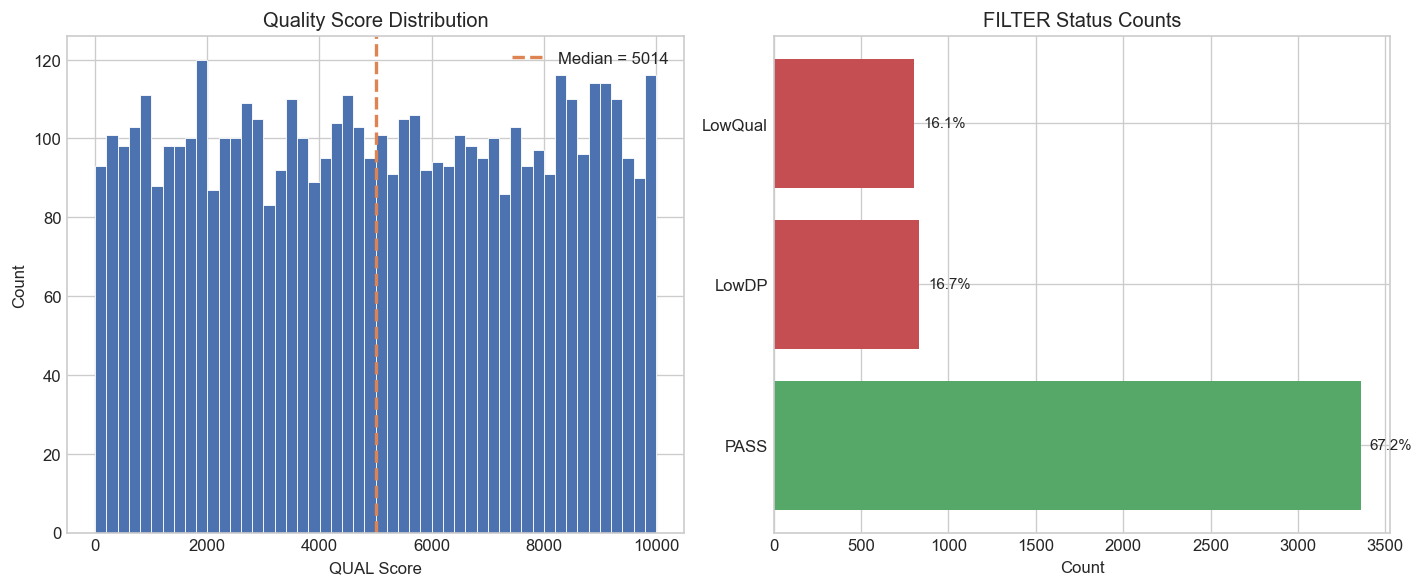

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))#Creates two plots that are 12 inches wide and 5 inches tall.

# Left: quality score histogram
ax1 = axes[0]#The left plot.
qual_vals = df_lg["QUAL"].dropna()#Removes rows from with missing values in the QUAL column.
ax1.hist(qual_vals, bins=50, color="#4C72B0", edgecolor="white", linewidth=0.5)#Creates a histogram with 50 bars and with the x axis as quality scores.
ax1.axvline(qual_vals.median(), color="#DD8452", linestyle="--", linewidth=2,#Add a red dashed line indicating the median quality score.
            label=f"Median = {qual_vals.median():.0f}")
ax1.set_xlabel("QUAL Score")#Set the x-axis label to QUAL Score.
ax1.set_ylabel("Count")#Set the y-axis label to Count.
ax1.set_title("Quality Score Distribution")#Set the title of the figure to Quality Score Distribution.
ax1.legend()#Create a legend that helps the viewer understand that the red dashed line is the Median.

# Right: filter status counts
ax2 = axes[1]#the right plot.
filter_counts = df_lg["FILTER"].value_counts()
colors_filter = ["#55A868" if f == "PASS" else "#C44E52" for f in filter_counts.index]
ax2.barh(filter_counts.index.astype(str), filter_counts.values, color=colors_filter)
ax2.set_xlabel("Count")
ax2.set_title("FILTER Status Counts")

# Add percentage labels
total = filter_counts.sum()
for i, (val, name) in enumerate(zip(filter_counts.values, filter_counts.index)):
    ax2.text(val + total * 0.01, i, f"{val/total*100:.1f}%", va="center", fontsize=9)

plt.tight_layout()#Automatically adjusts spacing so nothing gets cut off.
plt.savefig("test_data/quality_and_filters.png", dpi=150)#Saves the figure to a png file.
plt.show()#Displays the figure.

## 7. Test Coverage Summary

In [12]:
# Summarize what the test suite covers
coverage_areas = {
    "Uncompressed parsing":   True,
    "Compressed (.gz) parsing": True,
    "Compressed == Uncompressed output": True,
    "Column types (POS, QUAL)": True,
    "Categorical CHROM/FILTER": True,
    "Header: file format":    True,
    "Header: INFO fields":    True,
    "Header: FILTER fields":  True,
    "Header: contig fields":  True,
    "Header: sample IDs":     True,
    "Empty VCF file":         True,
    "Summary statistics":     True,
    "Parse time tracking":    True,
}#Creates a dictionary with the different tests and a boolean, to check if the test has been completed.

total = len(coverage_areas)#Number of tests.
covered = sum(coverage_areas.values())#Counts how many of the tests have been tested.
print(f"Test coverage areas: {covered}/{total} ({covered/total*100:.0f}%)")#Prints percentage of tests that have run.
print()
for area, status in coverage_areas.items():#Iterates through the coverage_areas dictionary.
    mark = "PASS" if status else "MISS"#If the boolean value is True, then mark the test as Pass, otherwise, set the boolean value to MISS.
    print(f"  [{mark}] {area}")#Print if the test Passed and the key value from the coverage_areas.

Test coverage areas: 13/13 (100%)

  [PASS] Uncompressed parsing
  [PASS] Compressed (.gz) parsing
  [PASS] Compressed == Uncompressed output
  [PASS] Column types (POS, QUAL)
  [PASS] Categorical CHROM/FILTER
  [PASS] Header: file format
  [PASS] Header: INFO fields
  [PASS] Header: FILTER fields
  [PASS] Header: contig fields
  [PASS] Header: sample IDs
  [PASS] Empty VCF file
  [PASS] Summary statistics
  [PASS] Parse time tracking
